In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import plotly.express as px
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('/Users/lorrainelu/Desktop/DLSPH/5230/final project/Diabetes Study File 10K Dec 14 2017.xlsx')

In [4]:
# Replace categorical values with numerical equivalents
data['DIABETES'].replace({'Yes' : 1, 'No' : 0}, inplace=True)
data['Sex'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Create indicator for using hypertension meds/corticosteroid
data['Use_of_Hypertension_Medications'] = data['Hypertension_Medications'].notnull().astype('int')
data['Use_of_Corticosteroids'] = data['Corticosteroids'].notnull().astype('int')

# Create a subset with no date
df = data[['Age_at_Exam', 'sBP', 'BMI', 'LDL', 'HDL', 'A1c', 'TG', 'FBS', 'Total_Cholesterol', 'Depression',
     'HTN', 'OA', 'COPD', 'Use_of_Hypertension_Medications', 'Use_of_Corticosteroids', 'Sex', 'DIABETES']]

In [5]:
X = df.drop(['DIABETES'], axis=1)
y = df[['DIABETES']]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Y_train = Y_train.to_numpy().ravel()
Y_test = Y_test.to_numpy().ravel()

In [15]:
# MICE imputation
imputer = IterativeImputer(max_iter=10, random_state=42)

# Initializing the Gradient Boosting Classifier with specified parameters
model = HistGradientBoostingClassifier(max_iter = 100, learning_rate=1.0, max_depth=1)

# Defining the hyperparameters to be tuned using GridSearchCV
param_dist = {
    "max_iter" : [100, 200],
    "max_depth" : [1, 3, 5],
    "min_samples_leaf" : [25, 50],
    "learning_rate" : [.1,  .2]
}

# Using StratifiedKFold for cross-validation, ensuring each fold has the same proportion of observations with each target value
skf = StratifiedKFold(n_splits=10)

# Setting up the GridSearchCV to find the best hyperparameters for the Gradient Boosting model
random_search = GridSearchCV(model, param_grid=param_dist, cv=skf)

# Creating a Pipeline:
# First, the data goes through the specified column transformations (ct)
# Then, the transformed data is used to train or predict using the Gradient Boosting model
mypip = Pipeline([
    ('mice', imputer),
    ('hist_boost', random_search) # hyperparameter tuning
])

In [17]:
# Training the Gradient Boosting model on the training dataset
mypip = mypip.fit(X_train, Y_train)

# Updating the model's parameters with the best ones found from GridSearchCV
model = model.set_params(**random_search.best_params_)

# Retraining the model with the best parameters on the training dataset
model = model.fit(X_train, Y_train)

# Predicting on the training dataset and computing the accuracy
Y_pred_training = model.predict(X_train)
accuracy_score(Y_train, Y_pred_training)

# Predicting on the test dataset and computing the accuracy
Y_pred_test = model.predict(X_test)
accuracy_score(Y_test, Y_pred_test)

0.8655

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4070
           1       0.86      0.90      0.88      3930

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1020
           1       0.85      0.88      0.87       980

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



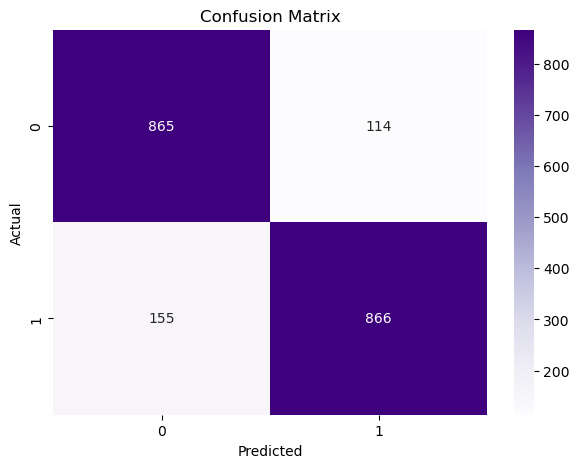

In [20]:
print(classification_report(Y_pred_training, Y_train))
print(classification_report(Y_pred_test, Y_test))

# Get unique classes
classes = df['DIABETES'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(Y_test, Y_pred_test),
            cmap='Purples', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()